In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sns
import pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from google.colab import drive
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from joblib import dump


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)

# data (as pandas dataframes)
X = aids_clinical_trials_group_study_175.data.features
y = aids_clinical_trials_group_study_175.data.targets

# metadata
print(aids_clinical_trials_group_study_175.metadata)

# variable information
print(aids_clinical_trials_group_study_175.variables)


{'uci_id': 890, 'name': 'AIDS Clinical Trials Group Study 175', 'repository_url': 'https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175', 'data_url': 'https://archive.ics.uci.edu/static/public/890/data.csv', 'abstract': 'The AIDS Clinical Trials Group Study 175 Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The prediction task is to predict whether or not each patient died within a certain window of time or not. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 2139, 'num_features': 23, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Sexual Orientation', 'Race', 'Gender'], 'target_col': ['cid'], 'index_col': ['pidnum'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1996, 'last_updated': 'Fri Nov 

In [3]:
sida_df = pd.read_csv('https://archive.ics.uci.edu/static/public/890/data.csv')
sida_df

,pidnum,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,10056,0,948,2,48,89.8128,0,0,0,100,...,0,0,1,0,1,0,422,477,566,324
1,10059,1,1002,3,61,49.4424,0,0,0,90,...,0,1,3,0,1,0,162,218,392,564
2,10089,0,961,3,45,88.4520,0,1,1,90,...,1,1,3,0,1,1,326,274,2063,1893
3,10093,0,1166,3,47,85.2768,0,1,0,100,...,1,1,3,0,1,0,287,394,1590,966
4,10124,0,1090,0,43,66.6792,0,1,0,100,...,1,1,3,0,0,0,504,353,870,782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,990021,0,1091,3,21,53.2980,1,0,0,100,...,1,1,3,0,1,1,152,109,561,720
2135,990026,0,395,0,17,102.9672,1,0,0,100,...,1,1,3,0,0,1,373,218,1759,1030
2136,990030,0,1104,2,53,69.8544,1,1,0,90,...,1,1,3,0,1,0,419,364,1391,1041
2137,990071,1,465,0,14,60.0000,1,0,0,100,...,1,0,1,0,0,0,166,169,999,1838


In [4]:
sida_df.columns

Index(['pidnum', 'cid', 'time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs',
       'karnof', 'oprior', 'z30', 'zprior', 'preanti', 'race', 'gender',
       'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80',
       'cd820'],
      dtype='object')

In [5]:
column_temp= sida_df['cid']
sida_bal = sida_df.drop(["cid"], axis=1)
#sida_df.insert(-1,"cid", move_cid)
sida_bal['cid']=column_temp

In [6]:
sida_bal

,pidnum,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,cid
0,10056,948,2,48,89.8128,0,0,0,100,0,...,0,1,0,1,0,422,477,566,324,0
1,10059,1002,3,61,49.4424,0,0,0,90,0,...,1,3,0,1,0,162,218,392,564,1
2,10089,961,3,45,88.4520,0,1,1,90,0,...,1,3,0,1,1,326,274,2063,1893,0
3,10093,1166,3,47,85.2768,0,1,0,100,0,...,1,3,0,1,0,287,394,1590,966,0
4,10124,1090,0,43,66.6792,0,1,0,100,0,...,1,3,0,0,0,504,353,870,782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,990021,1091,3,21,53.2980,1,0,0,100,0,...,1,3,0,1,1,152,109,561,720,0
2135,990026,395,0,17,102.9672,1,0,0,100,0,...,1,3,0,0,1,373,218,1759,1030,0
2136,990030,1104,2,53,69.8544,1,1,0,90,0,...,1,3,0,1,0,419,364,1391,1041,0
2137,990071,465,0,14,60.0000,1,0,0,100,0,...,0,1,0,0,0,166,169,999,1838,1


In [7]:
sida_df.dtypes

pidnum       int64
cid          int64
time         int64
trt          int64
age          int64
wtkg       float64
hemo         int64
homo         int64
drugs        int64
karnof       int64
oprior       int64
z30          int64
zprior       int64
preanti      int64
race         int64
gender       int64
str2         int64
strat        int64
symptom      int64
treat        int64
offtrt       int64
cd40         int64
cd420        int64
cd80         int64
cd820        int64
dtype: object

In [8]:
sida_df.shape

(2139, 25)

In [9]:
sida_df.zprior.value_counts()

1    2139
Name: zprior, dtype: int64

<Axes: >

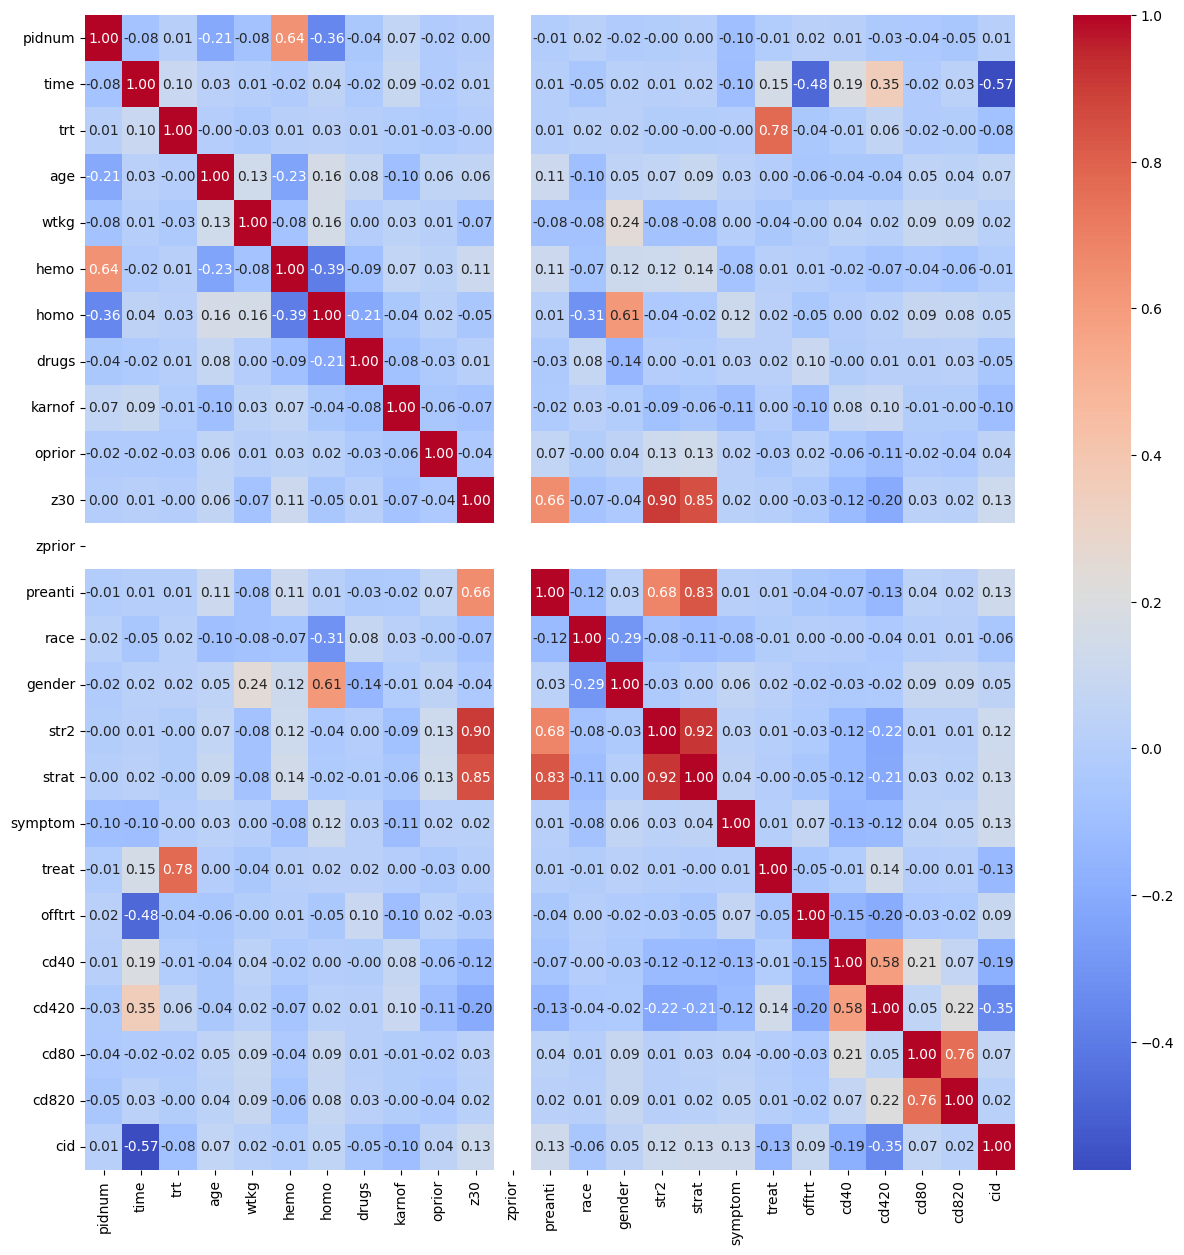

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(sida_bal.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

<Axes: xlabel='cid', ylabel='count'>

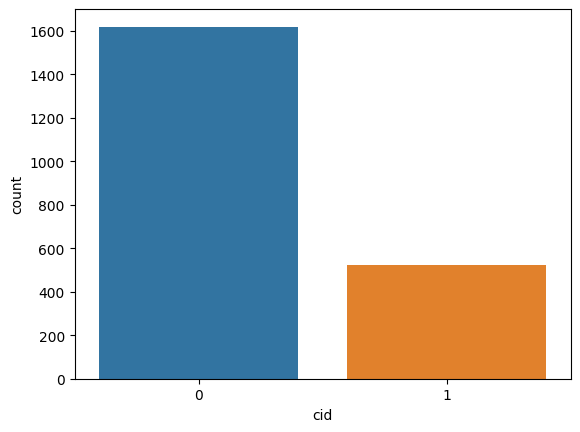

In [11]:
# sida_df.cid.value_counts()
# sns.histplot(data=sida_df,x='cd80',kde=1)
sns.countplot(data=sida_df,x='cid')
# sns.histplot(data=sida_df,x='cd820')
# sns.histplot(data=sida_df,x='cd40',kde=1)
# sns.histplot(data=sida_df,x='cd420')

<Axes: xlabel='cid', ylabel='count'>

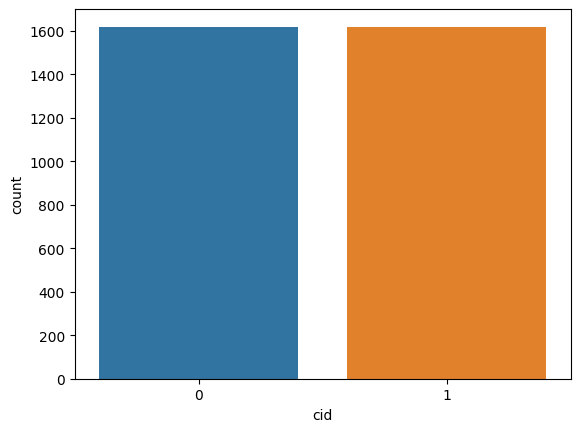

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
sida_bal_df, _ = smote.fit_resample(sida_df, sida_df['cid'])
sns.countplot(data=sida_bal_df,x='cid')

In [13]:
sida_bal_df

,pidnum,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,10056,0,948,2,48,89.812800,0,0,0,100,...,0,0,1,0,1,0,422,477,566,324
1,10059,1,1002,3,61,49.442400,0,0,0,90,...,0,1,3,0,1,0,162,218,392,564
2,10089,0,961,3,45,88.452000,0,1,1,90,...,1,1,3,0,1,1,326,274,2063,1893
3,10093,0,1166,3,47,85.276800,0,1,0,100,...,1,1,3,0,1,0,287,394,1590,966
4,10124,0,1090,0,43,66.679200,0,1,0,100,...,1,1,3,0,0,0,504,353,870,782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,10875,1,406,1,42,98.038008,0,1,0,91,...,1,1,3,0,1,0,257,161,1595,1089
3232,261015,1,704,0,30,72.133134,0,0,0,100,...,1,0,1,0,0,0,374,435,785,765
3233,180799,1,422,1,36,72.996943,0,1,0,85,...,1,0,1,0,0,0,297,409,830,882
3234,140743,1,353,1,41,79.544265,0,0,0,97,...,1,1,2,0,0,1,179,231,825,714


In [14]:
sida_bal_df.var()

pidnum     5.317827e+10
cid        2.500773e-01
time       9.446117e+04
trt        1.195994e+00
age        7.092901e+01
wtkg       1.558353e+02
hemo       6.842296e-02
homo       2.316676e-01
drugs      8.388655e-02
karnof     3.352111e+01
oprior     1.431758e-02
z30        2.491785e-01
zprior     0.000000e+00
preanti    2.098793e+05
race       1.678126e-01
gender     1.547432e-01
str2       2.445750e-01
strat      7.851382e-01
symptom    1.166170e-01
treat      2.308193e-01
offtrt     2.119223e-01
cd40       1.260717e+04
cd420      1.912746e+04
cd80       2.154724e+05
cd820      1.767951e+05
dtype: float64

In [15]:
sida_bal_df.describe().round(4)

,pidnum,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
count,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,...,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000,3236.0000
mean,247691.0532,0.5000,774.5590,1.3409,35.3922,75.1732,0.0739,0.6357,0.0924,94.9271,...,0.8087,0.5742,1.9747,0.1347,0.6388,0.3047,335.4654,340.1554,994.1446,934.0566
std,230604.1482,0.5001,307.3454,1.0936,8.4219,12.4834,0.2616,0.4813,0.2896,5.7897,...,0.3934,0.4945,0.8861,0.3415,0.4804,0.4604,112.2816,138.3021,464.1901,420.4701
min,10056.0000,0.0000,14.0000,0.0000,12.0000,31.0000,0.0000,0.0000,0.0000,70.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,49.0000,40.0000,124.0000
25%,90546.2500,0.0000,498.0000,0.0000,30.0000,67.2748,0.0000,0.0000,0.0000,90.0000,...,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,252.0000,241.0000,679.0000,647.7500
50%,191191.5000,0.5000,853.5000,1.0000,34.0000,74.5000,0.0000,1.0000,0.0000,99.0000,...,1.0000,1.0000,2.0000,0.0000,1.0000,0.0000,320.0000,318.0000,910.0000,866.5000
75%,271738.2500,1.0000,1054.0000,2.0000,40.0000,81.9913,0.0000,1.0000,0.0000,100.0000,...,1.0000,1.0000,3.0000,0.0000,1.0000,1.0000,407.0000,421.0000,1222.0000,1145.2500
max,990077.0000,1.0000,1231.0000,3.0000,70.0000,159.9394,1.0000,1.0000,1.0000,100.0000,...,1.0000,1.0000,3.0000,1.0000,1.0000,1.0000,1199.0000,1119.0000,5011.0000,6035.0000


In [16]:
from sklearn.model_selection import train_test_split
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(sida_bal_df.iloc[:,1:-2], sida_bal_df['cid'], test_size=test_size)
X = sida_bal_df.iloc[:,1:-2]
y = sida_bal_df['cid']

[6.25334867e-01 3.00496842e-01 5.67245229e-02 1.66709955e-02
 4.64532762e-04]


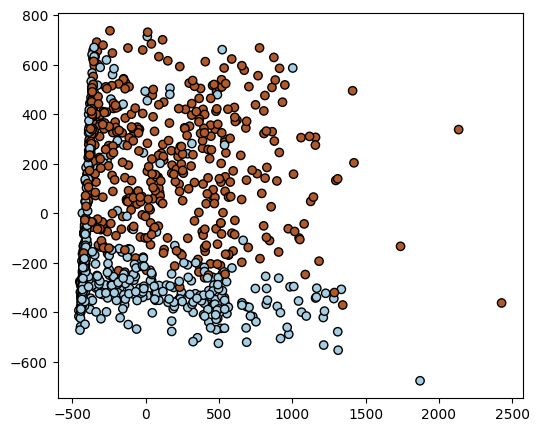

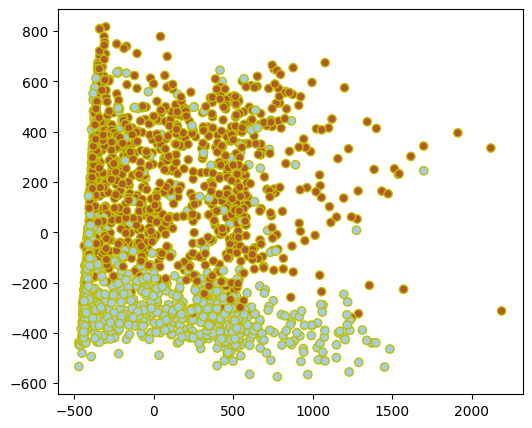

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform (X_test)
print (pca.explained_variance_ratio_)

_, ax =plt.subplots(figsize=(6,5))
train, p =plt.subplots(figsize=(6,5))

ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='Paired', edgecolors='k')
p.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='Paired', edgecolors='y')


In [18]:
X_test_pca.shape

(971, 5)

In [19]:
X_test.shape

(971, 22)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


<Axes: >

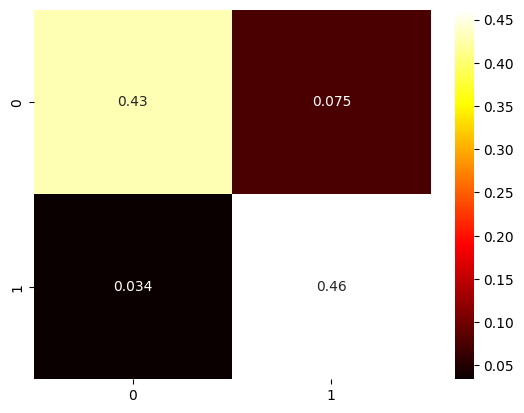

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

clf = XGBClassifier()

param_grid = {
    "learning_rate": (0.0005, 0.05, 0.1, 1, 10),
    "n_estimators": (50,100,200),
    "max_depth": (3,5,10)
}

rs = RandomizedSearchCV(clf, param_grid, scoring='f1', cv=8, n_iter=5)

rs.fit(X_train_pca, y_train)

print(rs.best_estimator_)

predictions = rs.best_estimator_.predict(X_test_pca)

cm= confusion_matrix(y_test, predictions, normalize = "all")
sns.heatmap(cm, annot=True, cmap='hot')

<Axes: >

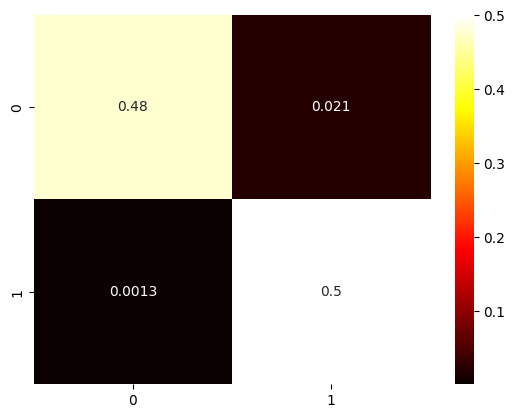

In [21]:
predictions = rs.best_estimator_.predict(X_train_pca)

cm= confusion_matrix(y_train, predictions, normalize = "all")
sns.heatmap(cm, annot=True, cmap='hot')

Arboles

In [22]:
clf = DecisionTreeClassifier()

param_grid = {
    "max_depth": (1, 2, 3, 4),
    "min_samples_leaf": (1, 2, 3),
    "criterion": ["gini", "entropy"]
}

gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=8)

gs.fit(X_train_pca, y_train)

best_grid_param = gs.best_params_
best_grid_score = gs.best_score_
print("La combinación de hiperparámetros para árboles de Decisión que mejor resultado entrega es", (best_grid_param))
print("La métrica que mejor ajusta los datos para el modelo de árboles de Decisión es de:", best_grid_score)

La combinación de hiperparámetros para árboles de Decisión que mejor resultado entrega es {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1}
La métrica que mejor ajusta los datos para el modelo de árboles de Decisión es de: 0.8706374732493903


XGBoost

In [23]:
clf = XGBClassifier()

param_grid = {
    "learning_rate": (0.0005, 0.05, 0.1, 1, 10),
    "n_estimators": (50,100,200),
    "max_depth": (3,5,10)
}

gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=8)

gs.fit(X_train_pca, y_train)

best_grid_param = gs.best_params_
best_grid_score = gs.best_score_
print("La combinación de hiperparámetros para XGBoost que mejor resultado entrega es", (best_grid_param))
print("La métrica que mejor ajusta los datos para el modelo XGBoost es de:", best_grid_score)

La combinación de hiperparámetros para XGBoost que mejor resultado entrega es {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
La métrica que mejor ajusta los datos para el modelo XGBoost es de: 0.8860735081869309


In [24]:
model_sel = XGBClassifier()
model_sel.fit(X_train_pca, y_train)
y_train_pred = model_sel.predict(X_train_pca)
y_test_pred = model_sel.predict(X_test_pca)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print('f1 para XGBoost en train {}'.format(f1_train))
print('f1 para XGBoost  en test {}'.format(f1_test))

f1 para XGBoost en train 1.0
f1 para XGBoost  en test 0.8984924623115578


In [29]:
# Definir el número de folds
num_folds = 5

# Crear el objeto KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Realizar k-fold cross-validation y obtener los puntajes de cada fold
puntajes = cross_val_score(model_sel, X_train_pca, y_train, cv=kf, scoring='accuracy')

# Imprimir los puntajes de cada fold y el puntaje promedio
print("Puntajes de cada fold:", puntajes)
print("Puntaje promedio:", puntajes.mean())
print("Puntaje std:", puntajes.std())
print("Puntaje var:", puntajes.var())

Puntajes de cada fold: [0.89183223 0.8785872  0.87417219 0.87637969 0.8785872 ]
Puntaje promedio: 0.8799116997792495
Puntaje std: 0.00618101545253862
Puntaje var: 3.8204952024521204e-05


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
dumb_xgboost = pickle.dumps(model_sel)
load_xgboost = pickle.loads(dumb_xgboost)
adaboost_prediction = load_xgboost.predict(X_train_pca)
save_pred = dump(model_sel,'/content/drive/MyDrive/ExpoING_2023/XGBoost_pred.joblib')